In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content


In [2]:
import os
os.chdir('/content/drive/My Drive/gc2ae/SN_keras/')
!ls

CBN.py				    img		 pyimagesearch
CIFAR10-ResNet-CrammerSinger.ipynb  losses	 ResNet-CrammerSinger-FM.ipynb
CIFAR10-ResNet.ipynb		    model.py	 SpectralNormalizationKeras.py
data_utils.py			    models	 train_Classifier.ipynb
GC2AE-CrammerSinger-FM.ipynb	    __pycache__


In [3]:
!pip install keras==2.1.5
%tensorflow_version 1.x
import keras
keras.__version__

     |████████████████████████████████| 337kB 3.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
TensorFlow 1.x selected.


Using TensorFlow backend.


'2.1.5'

In [0]:
%matplotlib inline
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

import numpy as np
import matplotlib.pyplot as plt
from time import time

from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
import keras.backend as K
from keras.utils.generic_utils import Progbar

from sklearn.utils import shuffle
import joblib

from model import *
from SpectralNormalizationKeras import *
from CBN import ConditionalAffine

In [0]:
from data_utils import onehotencode,sample_known_unknown_classes,\
sample_mismatch_labels,sample_mismatch_images,get_classwise, get_mapped_labels

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [0]:
# for resist GPU memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

In [7]:
from keras.datasets import cifar100, cifar10, mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#_,known_classes,unknown_classes = sample_known_unknown_classes(10,6)

known_classes = [9, 6, 0, 5, 3, 7]
unknown_classes = [8, 1, 2, 4]

known_class_mapping = {}
known_class_mapping_inv = {}
i=0
for kc in known_classes:
    known_class_mapping[kc] = i
    known_class_mapping_inv[i] = kc
    i+=1

In [0]:
def get_mismatch_data(x_known_classwise,y_known,known_classes,known_class_mapping):
    #Sample mismatch labels
    y_known_mismatch = sample_mismatch_labels(y_known,known_classes)
    #Sample mismatch images
    x_known_mismatch = sample_mismatch_images(x_known_classwise,y_known_mismatch)
    #Generate mapped labels
    y_known_mismatch_mapped = get_mapped_labels(y_known_mismatch,known_class_mapping)
    #Onehotencode mapped labels
    y_known_mismatch_mapped_ohe = onehotencode(y_known_mismatch_mapped+1,wgan=True)
    
    #Reshape arrays
    y_known_mismatch = y_known_mismatch.reshape((y_known_mismatch.shape[0],1))
    y_known_mismatch_mapped = y_known_mismatch_mapped.reshape((y_known_mismatch_mapped.shape[0],1))    
    if len(x_known_mismatch.shape)<4:
        x_known_mismatch = np.expand_dims(x_known_mismatch,axis=-1)
    
    return (x_known_mismatch, y_known_mismatch, y_known_mismatch_mapped, y_known_mismatch_mapped_ohe)

def get_known_unknown_data(x,y,known_classes,known_class_mapping,unknown_classes,unknown=False):
    #Known - Match
    y_known = y[np.where(np.isin(y,known_classes))]
    x_known = x[np.where(np.isin(y,known_classes))]
    
    x_known_classwise = get_classwise(x_known,y_known,known_classes)
    
    #Generate mapped labels
    y_known_mapped = get_mapped_labels(y_known,known_class_mapping)
    #Onehotencode mapped labels
    y_known_mapped_ohe = onehotencode(y_known_mapped+1,wgan=True)
    
    #Reshape arrays
    y_known = y_known.reshape((y_known.shape[0],1))
    y_known_mapped = y_known_mapped.reshape((y_known_mapped.shape[0],1))
    if len(x_known.shape)<4:
        x_known = np.expand_dims(x_known,axis=-1)
    
    #Known - Mismatch
    x_known_mismatch, y_known_mismatch,\
    y_known_mismatch_mapped, y_known_mismatch_mapped_ohe = get_mismatch_data(x_known_classwise,
                                                                             y_known,known_classes,
                                                                             known_class_mapping)        
    #Unknown
    if unknown:
        #y_unknown = y[np.where(np.isin(y,unknown_classes))]
        x_unknown = x[np.where(np.isin(y,unknown_classes))]

        if len(x_unknown.shape)<4:
            x_unknown = np.expand_dims(x_unknown,axis=-1)
            
        return (x_known, x_known_classwise, y_known, y_known_mapped, y_known_mapped_ohe), \
                (x_known_mismatch, y_known_mismatch, y_known_mismatch_mapped, y_known_mismatch_mapped_ohe),\
                (x_unknown)

    return (x_known, x_known_classwise, y_known, y_known_mapped, y_known_mapped_ohe), \
            (x_known_mismatch, y_known_mismatch, y_known_mismatch_mapped, y_known_mismatch_mapped_ohe)

In [0]:
#Hyperperemeter
BATCHSIZE=64
LEARNING_RATE = 0.0002
TRAINING_RATIO = 2
BETA_1 = 0.0
BETA_2 = 0.9
EPOCHS = 500
BN_MIMENTUM = 0.9
BN_EPSILON  = 0.00002
SAVE_DIR = 'img/generated_img_CIFAR10_ResNet/'

NUM_CLASSES = 10

LATENT_DIM = 128

USE_NOISE_GENERATOR = False

IMG_SHAPE = (28,28,1)

GENERATE_ROW_NUM = 8
GENERATE_BATCHSIZE = GENERATE_ROW_NUM*GENERATE_ROW_NUM

In [0]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

def crammer_singer_criterion(y_true, y_pred):
    mask = tf.math.equal(y_true,1) #Get indices for target labels
    mask_inv = tf.logical_not(mask) #Get indices for other labels
    
    shape1 = tf.stack((tf.shape(y_pred)[0],))
    shape2 = tf.stack((tf.shape(y_pred)[0],tf.shape(y_pred)[1]-1))
    
    #Predicted values for target label
    target = tf.reshape(tf.boolean_mask(y_pred,mask),shape1) 
    
    #Max predicted value for wrong label
    max_wrong = tf.math.reduce_max(tf.reshape(tf.boolean_mask(y_pred,mask_inv),
                                              shape2),axis=1)
    
    return tf.reduce_mean(tf.nn.relu(1 + max_wrong - target))

def fm_loss(y_true, y_pred):
    target_features_mean = tf.reduce_mean(y_true,axis=0)
    pred_features_mean = tf.reduce_mean(y_pred,axis=0)
    abs_diff = tf.math.abs(target_features_mean - pred_features_mean)
    return tf.reduce_mean(abs_diff)

In [12]:
def auroc(y_true, y_pred):
    try:
        return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    except:
        return -1

classifier = load_model('models/classifier/MNIST/classifier-save-20-0.002-0.030.hdf5',
                        custom_objects={'GlobalSumPooling2D':GlobalSumPooling2D,
                                        'auroc':auroc})
classifier.summary()











Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_______________________

In [23]:
encoder = classifier.layers[1]
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
Discriminator_resblock_Down_ (None, 14, 14, 128)       149636    
_________________________________________________________________
Discriminator_resblock_Down_ (None, 7, 7, 128)         312704    
_________________________________________________________________
Discriminator_resblock_1 (Mo (None, 7, 7, 128)         296192    
_________________________________________________________________
Discriminator_resblock_2 (Mo (None, 7, 7, 128)         296192    
_________________________________________________________________
activation_9 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
global_sum_pooling2d_1 (Glob (None, 128)               0         
Total para

In [0]:
generator = BuildGenerator(cbn=NUM_CLASSES,resblock3=False,
                           noise=True,
                           spectral_normalization=True,
                           out_channels=1,init_shape=(7,7,256),
                           in_shape=(LATENT_DIM,),
                           summary=False)

generator.load_weights('models/generator_ep250_mnist.h5')

#,custom_objects={'DenseSN':DenseSN,'ConvSN2D':ConvSN2D,'ConditionalAffine':ConditionalAffine}

In [0]:
x_train = (x_train - 127.5)/127.5
x_test = (x_test - 127.5)/127.5

assert (np.min(x_train) == -1) and (np.max(x_train) == 1)
assert (np.min(x_test) == -1) and (np.max(x_test) == 1)

(x_train_known,x_train_known_classwise,y_train_known,y_train_known_mapped,y_train_known_mapped_ohe),\
(x_train_known_mismatch, y_train_known_mismatch, y_train_known_mismatch_mapped, y_train_known_mismatch_mapped_ohe),\
(x_train_unknown) = get_known_unknown_data(x_train,y_train,known_classes,known_class_mapping,unknown_classes,unknown=True)

(x_test_known,x_test_known_classwise,y_test_known,y_test_known_mapped,y_test_known_mapped_ohe),\
(x_test_known_mismatch, y_test_known_mismatch, y_test_known_mismatch_mapped, y_test_known_mismatch_mapped_ohe),\
(x_test_unknown) = get_known_unknown_data(x_test,y_test,known_classes,known_class_mapping,unknown_classes,unknown=True)

In [42]:
x_train_unknown.shape

(24393, 28, 28, 1)

In [0]:
fake_y = np.ones_like(y_train_known_mismatch_mapped_ohe)*-1
fake_y[:,0] = 1

print(y_train_known_mismatch_mapped[:5])
print(y_train_known_mismatch_mapped_ohe[:5])
print(fake_y[:5])

assert np.sum(y_train_known_mismatch_mapped_ohe[:,0])*-1 == len(y_train_known_mismatch_mapped_ohe)
assert np.sum(fake_y[:,0]) == len(fake_y)

In [0]:
#Generate Match Mismatch Recon Errors
noise = np.random.randn(len(x_train_known), LATENT_DIM)

print('Generating embeddings')
encoder_output = encoder.predict(x_train_known)

print('Generating match reconstructions')
generated_match_recons = generator.predict([encoder_output,noise,
                                            y_train_known_mapped])

In [25]:
print('Generating mismatch reconstructions')
generated_mismatch_recons = generator.predict([encoder_output,noise,
                                               y_train_known_mismatch_mapped])
print(generated_match_recons.shape)
print(generated_mismatch_recons.shape)

Generating mismatch reconstructions
(35607, 28, 28, 1)
(35607, 28, 28, 1)


In [0]:
def mse(A,B):
    return np.square(np.subtract(A, B)).mean()

In [27]:
match_recon_errors = []
mismatch_recon_errors = []

for i in range(len(generated_match_recons)):
    match_recon_errors.append(mse(x_train_known[i],
                                  generated_match_recons[i]))
    mismatch_recon_errors.append(mse(x_train_known[i],
                                     generated_mismatch_recons[i]))
    if i%1000 == 0:
      print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000


(array([1.32305679e-03, 1.32305679e-03, 1.32305679e-02, 2.91072493e-02,
        5.82144987e-02, 8.59986912e-02, 1.42890133e-01, 2.13012143e-01,
        3.54579219e-01, 5.14669091e-01, 8.01772414e-01, 1.09284491e+00,
        1.51357697e+00, 2.04279968e+00, 2.23728903e+00, 2.45956257e+00,
        2.71623559e+00, 2.77577314e+00, 2.73343532e+00, 2.81943402e+00,
        2.82075707e+00, 2.67125166e+00, 2.67389777e+00, 2.71623559e+00,
        2.45162423e+00, 2.18701287e+00, 1.90520178e+00, 1.58237592e+00,
        1.31247233e+00, 1.05050709e+00, 8.57340799e-01, 6.36390315e-01,
        5.21284375e-01, 3.70455901e-01, 2.34181052e-01, 1.79935723e-01,
        1.15105941e-01, 6.74758962e-02, 4.23378172e-02, 4.23378172e-02,
        1.98458518e-02, 1.58766815e-02, 9.26139752e-03, 5.29222715e-03,
        6.61528394e-03, 1.32305679e-03, 2.64611358e-03, 1.32305679e-03,
        1.32305679e-03, 1.32305679e-03]),
 array([0.11168669, 0.13291357, 0.15414045, 0.17536733, 0.1965942 ,
        0.21782108, 0.2390

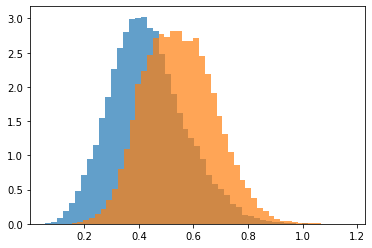

In [28]:
fig = plt.figure()
plt.hist(match_recon_errors,alpha=0.7,bins=50,density=True)
plt.hist(mismatch_recon_errors,alpha=0.7,bins=50,density=True)

[6]
[7]


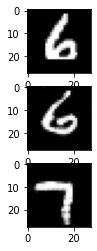

In [40]:
idx = np.random.randint(low=0,high=len(x_train_known))
print(y_train_known[idx])
print(y_train_known_mismatch[idx])

fig = plt.figure()
plt.subplot(311)
plt.imshow(x_train_known[idx,:,:,0],cmap='gray')

plt.subplot(312)
plt.imshow(generated_match_recons[idx,:,:,0],cmap='gray')

plt.subplot(313)
plt.imshow(generated_mismatch_recons[idx,:,:,0],cmap='gray')

In [41]:
discriminator, _ = BuildDiscriminatorCS(num_classes=len(known_classes),
                                        in_shape=IMG_SHAPE,feat=True,
                                        summary=False)

discriminator.load_weights('models/discriminator_ep250_mnist.h5')

Discriminator
Spectral Normalization: True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
Discriminator_resblock_Down_ (None, 14, 14, 128)       150020    
_________________________________________________________________
Discriminator_resblock_Down_ (None, 7, 7, 128)         313088    
_________________________________________________________________
Discriminator_resblock_1 (Mo (None, 7, 7, 128)         296448    
_________________________________________________________________
Discriminator_resblock_2 (Mo (None, 7, 7, 128)         296448    
_________________________________________________________________
activation_19 (Activation)   (None, 7, 7, 128)         0         
_________________________________________________________________
global_sum_pooling2d_1 (Glob (Non

In [43]:
print('Making known predictions')
discriminator_known_preds = discriminator.predict(x_train_known)

print('Making unknown predictions')
discrimiantor_unknown_preds = discriminator.predict(x_train_unknown)

Making known predictions
Making unknown predictions

(35607, 7)


NameError: ignored

In [44]:
print(discriminator_known_preds.shape)
print(discrimiantor_unknown_preds.shape)

(35607, 7)
(24393, 7)


(array([6.52029402e-02, 4.97261485e-03, 3.52066271e-03, 2.59552545e-03,
        1.21745563e-03, 4.91479449e-04, 2.37708872e-04, 6.74579635e-05,
        2.89105558e-05, 2.24859878e-05]),
 array([  5.0264773,  17.78854  ,  30.550604 ,  43.312668 ,  56.07473  ,
         68.83679  ,  81.598854 ,  94.36092  , 107.122986 , 119.88505  ,
        132.64711  ], dtype=float32),
 <a list of 10 Patch objects>)

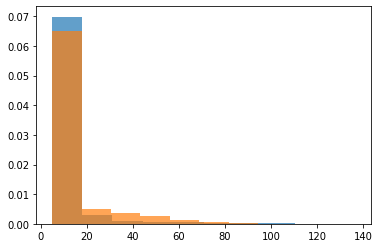

In [48]:
plt.hist(discriminator_known_preds[:,0], alpha=0.7, density=True)
plt.hist(discrimiantor_unknown_preds[:,0], alpha=0.7, density=True)